In [1]:
# Organización de datos
import pandas as pd
import numpy as np
import sympy

# Visualizacicón de datos
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Cálculo de ajustes matemáticos a los datos

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy import stats

import statsmodels.api as sm
alpha=0.05 # 95% confidence interval

# Funciones
# import funciones_jmp as f

C:\Users\juanm\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED



### 1. Leer y organizar el archivo que contiene los datos de absorbancia

**Unas primeras consideraciones:**

El archivo Excel debe estar organizado en 4 hojas: tiempo 0, tiempo 1, tiempo 2 y tiempo 3

Cada hoja debe tener una primera columna "uM" que indique la concentración de fármaco. Las siguientes se nombraran de la siguiente forma: R1,R2,R3,R4,R1,R2,R3,R4,R1,R2,R3,R4; ya que son las 3 réplicas de lectura consecutivas.

Se supone que la absorbancia a tiempo 0 es la misma para todas las concentraciones de fármaco, ya que se mide antes de añadir el tratamiento.

Se recomienda no trabajar con los datos de absorbancia que tengan más de 0.150 de diferencia con sus réplicas biológicas. Aquellos datos que se eliminen en Excel serán rellenados por la media de las réplicas en el programa.

In [2]:
def read_file_Marta_ntimes (file, ntimes):
    """
    Función para leer y organizar el archivo de Excel con los datos de absorbancia que vamos a utilizar
    
    Parámetros:
    file -- archivo Excel. Formato "ntimes" páginas seguidas: 0, 24, 48, 72 (SOLO TIEMPOS SEGUIDOS); 
    Formato columnas (réplicas seguidas para cada experimento):
        1ªcol: concentración, "uM"
        2ªcol: Réplica1, Experimento1, 
        3ªcol: Réplica2, Experimento1, 
        4ªcol: Réplica3, Experimento1, 
        5ªcol: Réplica1, Experimento2, 
        etc...
    
    Retorna:
    Una lista con DataFrames de los datos de los diferentes días (hojas de Excel)
    """
    DF_list = list()
    sheets = range(ntimes) # Lee tantas hojas como digamos en "ntimes" 0h, 24h, 48h, 72h
    
    # Bucle para que trabaje con todas las páginas
    for sheet in sheets:
        df = pd.read_excel(file,decimal='.',sheet_name=sheet)
        cols = df.columns
        df.set_index(cols[0], inplace=True)
        
        # Rellena los valores NaN con la media de las réplicas
        df_filled = df.T.fillna(df.mean(axis=1)).T          
        
#         DF_list.append(df1) ### Aquí añade 4 columnas con las medias
        DF_list.append(df_filled)
    return DF_list


In [3]:
def log_MTT_err_C_t_exp_colnoname(dfs, n_exp):
    """
    Función para promediar datos de absorbancia por experimento y salida en log.
    Las columnas de las réplicas deben ir seguidas para cada experimento. El número total de columnas
    será (sin contar la columna de concentraciones):
             nºréplicas X nº experimentos
    
    Parámetros:
    dfs -- lista de DataFrames (uno por cada tiempo);
    Formato columnas (réplicas seguidas para cada experimento):
        1ªcol: concentración, "uM"
        2ªcol: Réplica1, Experimento1, etc
    Retorna:
     Concentr, logs_C_t_exp, err_logs_C_t_exp    
    """    
    
    n_times = len(dfs)
    shape = dfs[0].shape
    print('shape:', shape)

    n_rep = int(shape[1]/n_exp)

    n_Conc = len(dfs[0].index)
    Concentr = dfs[0].index.values
    print('n_times:', n_times, 'n_Conc:', n_Conc,'n_exp:', n_exp,'n_rep:',n_rep)
    
    colums = dfs[0].columns    
    cols_exp = {}
    for exp in range(n_exp): ## define columuns for each experiment
        exp_name = 'Exp'+str(exp+1)
#         cols_ex = [cols[j+exp*n_rep] for cols in colums for j in range(n_rep) ]
#         cols_exp[exp_name] = cols_ex
        cols=[]
        for j in range(n_rep):
            cols.append(colums[j+exp*n_rep] )
        cols_exp[exp_name] = cols              ## dictionary[experiment name] = cols names 
        print('exp_name:', exp_name, 'cols_exp', cols_exp[exp_name])

    logs_C_t_exp = np.zeros((n_Conc, n_times, n_exp) )
    err_logs_C_t_exp = np.zeros((n_Conc, n_times, n_exp) )
    
    print('size of logs_C_t_exp:',logs_C_t_exp.shape)

    for i_C, C in zip( range(n_Conc), Concentr):
        print(i_C, C)
        #         array_log_iC = []
        for i_t in range(n_times):
            
            for exp in range(n_exp):
                exp_name = 'Exp'+str(exp+1)
                col_name = cols_exp[exp_name]   ## current cols names
                print(col_name)
                MTT_exp_mean = dfs[i_t].loc[C,col_name].values.mean() #DataFrame of concentration index: i_c 
                MTT_exp_err = dfs[i_t].loc[C,col_name].values.std() #DataFrame of concentration index: i_c 

                print('i_C:',i_C,'i_t:', i_t,'exp:', exp_name, '; MTT_exp_mean:',MTT_exp_mean, ', MTT_exp_err:',MTT_exp_err)
                logs_C_t_exp[i_C, i_t, exp] = np.log(MTT_exp_mean)
                err_logs_C_t_exp[i_C, i_t, exp] = (MTT_exp_err/MTT_exp_mean)
                

    return Concentr, logs_C_t_exp, err_logs_C_t_exp

In [4]:
def f_lin(x, a, b):
    """
    Función exponencial negativa de la forma más función lineal y = a * exp(-b * x) - c -m*x

    Parámetros:
    x -- valor de entrada
    a, b, c, m -- parámetros de la función exponencial (c>0)

    Retorna:
    El valor de la función exponencial evaluada en x
    """
    return  a*x + b

In [5]:
def r_experim_error_boot_pairs_estad(X,y,error_y, n_boot, name, save=False):

    '''
    Calcula el valor de la tasa de crecimiento por el método de Bootstrap: itera tomando al azar valores
    aleatorios en el rango entre ymin-ymax, calculados con los valores medios de las replicas (de cada experimento)
    y ajusta una recta (eso para cada concentración), 
    y lo va promediando los ajustes de las distintas rectas obtenidas por bootstrap:
    SE = sqrt( (slope-slope_mean)**2 / (nboot-2))
    Interv_95% = 1,96 *SE
    Devuelve el valor de las tasas de crecimiento y sus desviaciones:
    r_c y  Delta_r_C
    '''
    X0=np.array(X).ravel()
    y0=np.array(y).ravel()
    e =np.array(error_y).ravel()
#     e=np.array(e).ravel()

    print('X:',X0)
    print('y:',y0)
#     print('shape X0:', X0.shape, 'y0:', y0.shape)
#     print('e:',e)
    n_samples=len(X0)
    print('n_samples:', n_samples)

#     Ajuste exponencial utilizando curve_fit y ajuste de los parámetros
    popt, pcov = curve_fit(f_lin, X0, y0) # y_transformed
    y_hat = f_lin(X0, *popt)
    resid = y0 - y_hat
    print('resid:', resid)
    print('n_boot:', n_boot)
    n_points = n_boot
    n_samples = len(X0)
    n_param = 2       ## Linear fit    

    fig = plt.figure(figsize=(10,10))
    gs = GridSpec(2, 2, figure=fig)
    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[1, 1])
        
    y_hat_b = np.zeros((n_boot, n_samples), dtype=float)
    slopes_b = np.zeros(n_boot, dtype=float)
    params_b = np.zeros((n_boot, n_param), dtype=float)
    resids_b = np.zeros((n_boot, n_samples), dtype=float)
    r2_b = np.zeros((n_boot), dtype = float)
    
    npoints_plot = 1000
    X_plot = np.linspace(0,X0[-1],npoints_plot)
#     y_plot_b = np.zeros((n_boot, npoints_plot), dtype=float)
#     creciente = np.all(np.diff(X0) > 0)
#     print('Orden creciente:', creciente)
          
    nfit=0
    i_fit=0
    res_b = 0
    for i in range(n_boot):
#         print('iter/n_iter:',i, '/',n_boot)
            # Bootstrap: resample data with replacement
        i_index = np.random.choice(range(0, len(X0)), len(X0))
#         resid_boot = resid[i_index]
#         print('shapes:', X0.shape, A.shape, B.shape, resid_boot.shape)
#         print('resid_boot:', resid_boot)
#         y_boot = f_lin(X0, *popt) + resid_boot

        X_boot = X0[i_index]    
        y_boot = y0[i_index]
#         print('X_boot, y_boot:', X_boot, y_boot)

        try:
#             popt_b, pcov_b = curve_fit(f_lin, X0, y_boot)
            popt_b, pcov_b = curve_fit(f_lin, X_boot, y_boot)
#             print('param:',popt_b, 'pcov:', pcov_b[0][0])
            all_lt_10 = (np.abs(popt_b)<10).all() and (np.sqrt(pcov_b[0][0])<10) ##TODOS los parámetros tienen que ser < 2
            if all_lt_10:
                y_hat_i = f_lin(X_boot, *popt_b)
                res_b = y_boot - y_hat_i

#                 y_hat = f_lin(X0, *popt_b)
#                 res_b += y0 - y_hat_b
                y_hat_b[i_fit,:] = y_hat_i
#                 creciente = np.all(np.diff(np.flip(y_hat)) > 0)
#                 if creciente:
#                      print('creciente:', creciente)
                params_b[i_fit,:] = popt_b[:]
                resids_b[i_fit,:] = res_b
                r2_b[i_fit] = r2_score(y_boot, y_hat_i)
    
#                 print('params_b:', params_b[i_fit,:])

                y_plot = f_lin(X_plot, *popt_b)
#                 y_plot_b[i_fit,:] = y_plot
                ax1.plot(X_plot, y_plot, color='grey', alpha=0.2, zorder=1)
#                 ax1.scatter(X0, y_boot, marker='o', color='orange', zorder=2)
                plt.scatter(X_boot, y_boot, marker='o', color='orange', zorder=2)
#                 ax1.scatter(X_boot, y_boot, marker='o', color='orange', zorder=2)
                i_fit += 1
#                 print('fit Ok, i',i, ', i_fit:', i_fit)
            
        except:
            print('error in curve_fit, i:',i,'\n')
    nfit = i_fit
    res_b /= nfit        
################
    print('i_fit:',i_fit, 'nfit:', nfit)    
    params_mean = np.mean(params_b[:nfit,:], axis=0)
    print('params_mean:', params_mean)
    slope_mean = params_mean[0]
    print('mean slope:', slope_mean)
    y_hat_mean = np.mean(y_hat_b, axis=0)

#     sum_res2 = np.sum((y_hat_b[:nfit] - y_hat_mean)**2) 
#     SE_A = np.sqrt(n_samples/(n_samples-1)) * np.sqrt( sum_res2 / (nfit-1)) ## 2 degrees of freedom
#     Interv_A = 1.96 * SE_A
    # Standard deviation for the residuals
    # Student's t-value for n-2 degrees of freedom, 90% confidence
    sum_res2 = np.sum((params_b[:nfit,0] - params_mean[0])**2) 
    SE_A = np.sqrt(n_samples/(n_samples-1)) * np.sqrt( sum_res2 / (nfit-1)) ## Chapter21 -Segapub
    t = stats.t.ppf(0.95, n_samples-2) 
    Interv_A = t * SE_A
    print('pendiente media:', slope_mean,'; interval_90%:', Interv_A)
        
    ymin_plot, ymax_plot = plt.ylim()
    xmin_plot, xmax_plot = plt.xlim()
    print('ymin', ymin_plot)
    ax1.margins(0.01)
    
#     plt.errorbar(X0, y0, yerr=e, label='Data', fmt='o', ecolor='orange')

    ax1.plot(X_plot, f_lin(X_plot, params_mean[0], params_mean[1]),'r',label="slope={:.3f}; Interv={:.3f}".format(slope_mean, Interv_A))
#     colors=['b','g','brown', 'yellow']
#     for j in range(n_exp):
#         X_plot = np.array(X0[j::n_exp]).reshape(-1, 1)
#         y_plot = np.array(y0[j::n_exp])
#         e_plot = np.array(e[j::n_exp])
#         plt.errorbar(X_plot, y_plot, yerr=e_plot, fmt='o', label='exp{:}'.format(j+1))
    
    ax1.set_xlabel('Tiempo (días)')
    ax1.set_ylabel('ln(N)')
    title_ax1 = 'Growth rate ('+name+ ')' +'_boot_pairs_all'
    ax1.set_title(title_ax1)
    ax1.grid(True)
    ax1.legend()
    
    
    n_bins=20

    residuos = resids_b[:nfit,:].ravel()
    print('residuos:', residuos)
    
#     r2_plot = r2_b[:nfit].ravel()
#     print('r^2_min:', r2_plot.min(), ';   resid_max:',r2_plot.max())
#     ax2.hist(r2_plot, density=False, bins=n_bins, range=(r2_plot.min(), r2_plot.max()), histtype='barstacked', rwidth=0.8)
#     ax2.set_title('r^2 distrib.')
    ax2.hist(residuos, density=False, bins=n_bins, range=(residuos.min(), residuos.max()), histtype='barstacked', rwidth=0.8)
    ax2.set_title('residuals distrib.')    

    ax1b = plt.axes([.71, .57, .15, .15], facecolor='lightgrey')
    ax1b.scatter(X0, resid)
    ax1b.axhline(0, color='k')
    x_labelsize = ax1.get_xticklabels()[0].get_size()
    y_labelsize = ax1.get_yticklabels()[0].get_size()
    x_labelsize *= 0.8
    y_labelsize *= 0.8
    ax1b.xaxis.set_tick_params(labelsize=x_labelsize)
    ax1b.yaxis.set_tick_params(labelsize=y_labelsize)
    ax1b.set_xticks([0, 1, 2, 3])
    ax1b.set_title('residuals')

    
#     ax2.set_xlim((0,50))   
    print('slopes:', params_b[:nfit,0])
    ax3.hist(params_b[:nfit,0], bins=n_bins, range=(params_b[:nfit,0].min(), params_b[:nfit,0].max()), histtype='barstacked', rwidth=0.8)
    ax3.set_xlim(( params_b[:nfit,0].min(), params_b[:nfit,0].max()))
    ax3.set_title('slopes distrib.')
    
    if save:
        filename = name + '_boot_pairs_all.jpg'
        plt.savefig(filename)
        print('figure saved as ', filename)

    
    plt.show()  
    
#     print('Slope:', A, 'error(90%):',Interv_A)
    return slope_mean, Interv_A

In [6]:
def save_C_prom_r_boot_pairs_error(Concentr, prom_r_conc, error_r_conc, name):
    
    r_tot_C = []
    err_r_C = []
    # r2_C = []
    # concentr = dfs[0].index.values
    cols = ['concentr', 'prom_r', 'err_r']

    data = np.zeros([len(Concentr), 3])

    for i_C in range(len(Concentr)):

        print('i:',i_C,'Conc:', Concentr[i_C], 'r:', prom_r_conc[i_C],'error:', error_r_conc[i_C],'\n\n')
#         r_tot_C.append(y_conc[i_C])
#         err_r_C.append(error_y_conc[i_C])
            #     r2_C.append(r2_i)
        data[i_C] = [Concentr[i_C], prom_r_conc[i_C], error_r_conc[i_C]]
#     data = np.array([Concentr, prom_r_conc, error_r_conc])
    print('data:', data)
    df_r_C = pd.DataFrame(data,columns=cols)

#     print('r:',r_tot_C)
#     print('error_r:', err_r_C)
    # print('r2:',r2_C)

    filename = name + '_r_boot_pairs_all_err.xlsx'
    df_r_C.to_excel(filename)
    print('slopes and errors saved as ', filename)
 
    return

In [9]:
# name = 'PA00_100norm'
# filename = name + '_24abr.xlsx'
name = 'SW620norm' #'HCT116'
filename = name + '_nov23_days123.xlsx' #'SW480_oct23.xlsx')


############# Indicar aquí cuántos días se van a estudiar 2, 3 ó 4
n_times = 3

dfs = read_file_Marta_ntimes(filename, n_times)


In [12]:
dfs[2]

,R1_Exp1,R2_Exp1,R3_Exp1,R1_Exp2,R2_Exp2,R3_Exp2,R1_Exp3,R2_Exp3,R3_Exp3
uM,,,,,,,,,
0.000000,1.222510,1.232859,1.173351,2.081577,1.385885,2.065078,1.773046,1.820303,1.829055
0.097656,1.024580,1.046572,1.098318,1.781852,1.696609,1.685610,2.016336,2.039090,1.970828
0.195312,0.948254,0.984476,1.005175,1.451879,1.449129,1.319890,1.759043,1.738040,1.471995
0.390625,0.970246,0.884864,0.941785,1.410632,1.372136,1.350137,1.661027,1.627771,1.666278
0.781250,0.940492,0.868047,1.019405,1.493126,1.220898,1.427131,1.682030,1.671529,1.808051
1.562500,0.742561,0.803364,0.808538,1.102658,1.295142,1.317140,1.613769,1.587515,1.559510
3.125000,0.721863,0.624838,0.642950,1.196150,1.198900,1.149404,1.519253,1.538506,1.382730
6.250000,0.827943,0.657180,0.728331,1.193401,1.124656,1.174152,1.389732,1.310968,1.211202
12.500000,0.852523,0.818887,0.826649,1.132906,1.108158,1.031164,1.293466,1.275963,1.211202


In [13]:
## calcula el Ln del valor medio de las réplicas de cada experimento y su error

alpha = 0.05 # 95% confidence interval

#################### OJO  Nº EXPERIMENTOS
#### Para considerar todos las réplicas para hacer bootstrap nºexperimentos = 9

n_exp = len(dfs[0].columns)
n_rep=1
#########################################

# n_Conc = len(dfs[0].index)
colums = dfs[0].columns
Concen = dfs[0].index.values

# Concentr, logs_C_t_exp, err_logs_C_t_exp= log_MTT_err_C_t_exp_colnoname(dfs, n_exp)

### Calculo del error como la dispersión : (mayor - menor)/2
Concentr, logs_C_t_exp, err_logs_C_t_exp= log_MTT_err_C_t_exp_colnoname(dfs, n_exp)



n_times = len(dfs)
print(Concentr)
print(logs_C_t_exp)
# print(err_logs_C_t_exp)

shape: (11, 9)
n_times: 3 n_Conc: 11 n_exp: 9 n_rep: 1
exp_name: Exp1 cols_exp ['R1_Exp1']
exp_name: Exp2 cols_exp ['R2_Exp1']
exp_name: Exp3 cols_exp ['R3_Exp1']
exp_name: Exp4 cols_exp ['R1_Exp2']
exp_name: Exp5 cols_exp ['R2_Exp2']
exp_name: Exp6 cols_exp ['R3_Exp2']
exp_name: Exp7 cols_exp ['R1_Exp3']
exp_name: Exp8 cols_exp ['R2_Exp3']
exp_name: Exp9 cols_exp ['R3_Exp3']
size of logs_C_t_exp: (11, 3, 9)
0 0.0
['R1_Exp1']
i_C: 0 i_t: 0 exp: Exp1 ; MTT_exp_mean: 1.0219922380336353 , MTT_exp_err: 0.0
['R2_Exp1']
i_C: 0 i_t: 0 exp: Exp2 ; MTT_exp_mean: 0.9948253557567918 , MTT_exp_err: 0.0
['R3_Exp1']
i_C: 0 i_t: 0 exp: Exp3 ; MTT_exp_mean: 0.9831824062095731 , MTT_exp_err: 0.0
['R1_Exp2']
i_C: 0 i_t: 0 exp: Exp4 ; MTT_exp_mean: 0.9816681943171403 , MTT_exp_err: 0.0
['R2_Exp2']
i_C: 0 i_t: 0 exp: Exp5 ; MTT_exp_mean: 1.0284142988084326 , MTT_exp_err: 0.0
['R3_Exp2']
i_C: 0 i_t: 0 exp: Exp6 ; MTT_exp_mean: 0.9899175068744271 , MTT_exp_err: 0.0
['R1_Exp3']
i_C: 0 i_t: 0 exp: Exp7 ; MTT_

i_C: 5 i_t: 1 exp: Exp2 ; MTT_exp_mean: 1.001293661060802 , MTT_exp_err: 0.0
['R3_Exp1']
i_C: 5 i_t: 1 exp: Exp3 ; MTT_exp_mean: 1.034928848641656 , MTT_exp_err: 0.0
['R1_Exp2']
i_C: 5 i_t: 1 exp: Exp4 ; MTT_exp_mean: 1.4161319890009167 , MTT_exp_err: 0.0
['R2_Exp2']
i_C: 5 i_t: 1 exp: Exp5 ; MTT_exp_mean: 1.5426214482126492 , MTT_exp_err: 0.0
['R3_Exp2']
i_C: 5 i_t: 1 exp: Exp6 ; MTT_exp_mean: 1.4546287809349223 , MTT_exp_err: 0.0
['R1_Exp3']
i_C: 5 i_t: 1 exp: Exp7 ; MTT_exp_mean: 1.0239206534422403 , MTT_exp_err: 0.0
['R2_Exp3']
i_C: 5 i_t: 1 exp: Exp8 ; MTT_exp_mean: 1.0099183197199533 , MTT_exp_err: 0.0
['R3_Exp3']
i_C: 5 i_t: 1 exp: Exp9 ; MTT_exp_mean: 0.9871645274212367 , MTT_exp_err: 0.0
['R1_Exp1']
i_C: 5 i_t: 2 exp: Exp1 ; MTT_exp_mean: 0.742561448900388 , MTT_exp_err: 0.0
['R2_Exp1']
i_C: 5 i_t: 2 exp: Exp2 ; MTT_exp_mean: 0.8033635187580853 , MTT_exp_err: 0.0
['R3_Exp1']
i_C: 5 i_t: 2 exp: Exp3 ; MTT_exp_mean: 0.8085381630012937 , MTT_exp_err: 0.0
['R1_Exp2']
i_C: 5 i_t: 2

## Calculo de las tasas de crecimiento con TODOS los datos con Bootstrap por pares (x_i, y_i)

tiempo: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2]
i_c: 0 Concentr: 0.0
SW620norm_C0p0
X: [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2]
y: [ 2.17538969e-02 -5.18807908e-03 -1.69606153e-02 -1.85019154e-02
  2.80181002e-02 -1.01336657e-02  9.86945602e-03 -2.72045162e-02
  1.67779464e-02  1.12450458e-01  1.96664091e-01  1.62066046e-01
  3.34243750e-01  3.89760397e-01  2.04081255e-01 -5.83600834e-04
  8.17466675e-02  4.65658583e-03  2.00905879e-01  2.09335855e-01
  1.59863402e-01  7.33125556e-01  3.26338571e-01  7.25167955e-01
  5.72698694e-01  5.99003182e-01  6.03799354e-01]
n_samples: 27
resid: [ 0.04338194  0.01643996  0.00466742  0.00312612  0.04964614  0.01149437
  0.0314975  -0.00557648  0.03840599 -0.09546638 -0.01125275 -0.0458508
  0.12632691  0.18184356 -0.00383559 -0.20850044 -0.12617017 -0.20326026
 -0.23655584 -0.22812587 -0.27759832  0.29566384 -0.11112315  0.28770623
  0.13523697  0.16154146  0.16633763]
n_boot: 2000
i_fit: 20

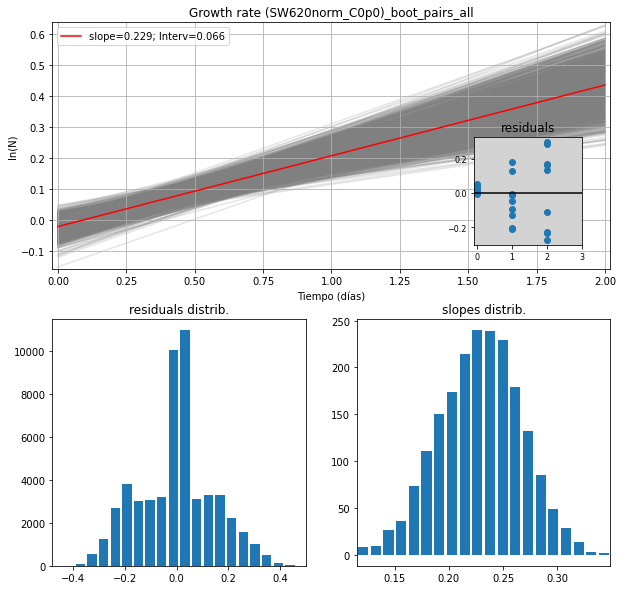

i_c: 1 Concentr: 0.09765625
SW620norm_C0p1
X: [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2]
y: [ 0.0217539  -0.00518808 -0.01696062 -0.01850192  0.0280181  -0.01013367
  0.00986946 -0.02720452  0.01677795  0.16096533  0.11129372  0.04180469
  0.27127879  0.3203684   0.51393718  0.04728879  0.00116618  0.00986946
  0.02428234  0.04551987  0.09378014  0.577653    0.52863133  0.52212724
  0.70128203  0.71250356  0.678454  ]
n_samples: 27
resid: [ 3.90897363e-02  1.21477604e-02  3.75224137e-04 -1.16607594e-03
  4.53539397e-02  7.20217373e-03  2.72052955e-02 -9.86867680e-03
  3.41137858e-02 -3.75767686e-02 -8.72483784e-02 -1.56737405e-01
  7.27366951e-02  1.21826305e-01  3.15395086e-01 -1.51253311e-01
 -1.97375918e-01 -1.88672643e-01 -3.90137693e-01 -3.68900168e-01
 -3.20639899e-01  1.63232962e-01  1.14211290e-01  1.07707202e-01
  2.86861994e-01  2.98083519e-01  2.64033962e-01]
n_boot: 2000
i_fit: 2000 nfit: 2000
params_mean: [ 0.21483017 -0.01868064]
mean slope: 0.214830168982630

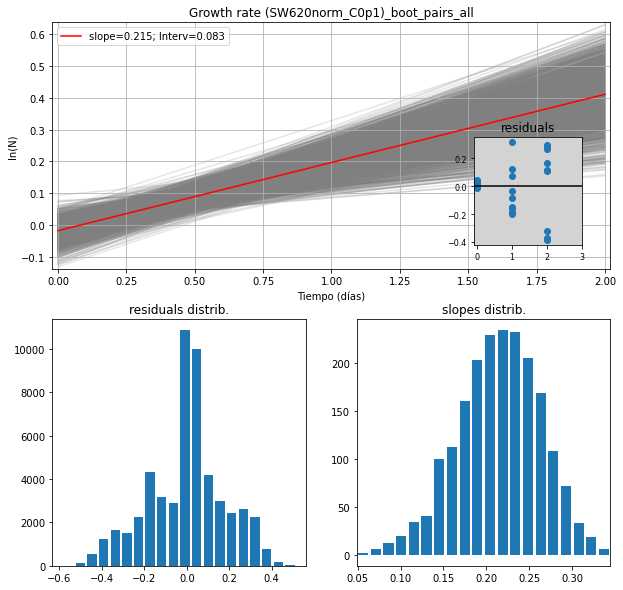

i_c: 2 Concentr: 0.1953125
SW620norm_C0p2
X: [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2]
y: [ 0.0217539  -0.00518808 -0.01696062 -0.01850192  0.0280181  -0.01013367
  0.00986946 -0.02720452  0.01677795  0.08193166  0.09965215 -0.0288734
  0.36142989  0.43704193  0.42812127 -0.01469318 -0.00585139 -0.00409238
 -0.05313335 -0.01564569  0.0051613   0.37285859  0.37096285  0.27754841
  0.56477001  0.55275785  0.38661885]
n_samples: 27
resid: [ 0.01731709 -0.00962488 -0.02139742 -0.02293872  0.0235813  -0.01457047
  0.00543265 -0.03164132  0.01234114 -0.05936449 -0.041644   -0.17016954
  0.22013374  0.29574578  0.28682512 -0.15598933 -0.14714754 -0.14538852
 -0.33128884 -0.29380118 -0.27299419  0.09470309  0.09280736 -0.00060709
  0.28661452  0.27460236  0.10846336]
n_boot: 2000
i_fit: 2000 nfit: 2000
params_mean: [0.13722561 0.00539674]
mean slope: 0.137225607459647
pendiente media: 0.137225607459647 ; interval_90%: 0.06931457482533797
ymin -0.08402851453598705
residuos: [-0.17

KeyboardInterrupt: 

In [14]:
tiempo = [i for i in range(n_times) for _ in range(n_exp)]
print('tiempo:', tiempo)
X = np.array(tiempo).reshape(-1, 1)  

n_boot= 2000

slopes=[]
err_slopes=[]
for i_C in range(len(Concentr)):

    print('i_c:', i_C,'Concentr:',Concentr[i_C])
    y = logs_C_t_exp[i_C]
    e = err_logs_C_t_exp[i_C]   

    Concent_str = str(np.round(Concentr[i_C], 2))
    name_C = name + '_C'+ Concent_str.replace('.','p')
    print(name_C)

#     slope_i, error_slope_i = r_experim_error_boot_resid(X,y, e, n_boot,  name_C, True)
    slope_i, error_slope_i = r_experim_error_boot_pairs_estad(X,y, e, n_boot,  name_C, False) ### pinta estadística

    
    slopes.append(slope_i)
    err_slopes.append(error_slope_i)
    
print('slopes:', slopes,'; con error al 90% confianza:', err_slopes)
# save_C_prom_r_boot_resid_error(Concentr, slopes, err_slopes, name)

In [26]:
n_exp

12

In [27]:
save_C_prom_r_boot_pairs_error(Concentr, slopes, err_slopes, name)

i: 0 Conc: 0.0 r: 0.33793143081413035 error: 0.026900757193751287 


i: 1 Conc: 1.5625 r: 0.34941976168566463 error: 0.026594932690464583 


i: 2 Conc: 3.125 r: 0.31851034841054904 error: 0.025786323514379053 


i: 3 Conc: 6.25 r: 0.3132091590118947 error: 0.030883242008776148 


i: 4 Conc: 12.5 r: 0.24901102442625983 error: 0.023662285534846686 


i: 5 Conc: 25.0 r: 0.1738634152841316 error: 0.010618020291804435 


i: 6 Conc: 50.0 r: 0.05877305013097485 error: 0.01521008478792592 


i: 7 Conc: 100.0 r: -0.12995897300356526 error: 0.013476527516812003 


i: 8 Conc: 150.0 r: -0.31040141531505294 error: 0.02279697441732794 


data: [[ 0.00000000e+00  3.37931431e-01  2.69007572e-02]
 [ 1.56250000e+00  3.49419762e-01  2.65949327e-02]
 [ 3.12500000e+00  3.18510348e-01  2.57863235e-02]
 [ 6.25000000e+00  3.13209159e-01  3.08832420e-02]
 [ 1.25000000e+01  2.49011024e-01  2.36622855e-02]
 [ 2.50000000e+01  1.73863415e-01  1.06180203e-02]
 [ 5.00000000e+01  5.87730501e-02  1.52100848e-02]
 [ 1.

<ipython-input-6-7d3d1e9f9202>:27: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.7' currently installed).
  df_r_C.to_excel(filename)


In [ ]:
#### Calcula el eror a partir de la dispersión: (mayor-menor)/2.  Da resultados muy parecidos, así que usamos la "std" que usa todo el mundo
def log_MTT_err_C_t_exp_colnoname_disp(dfs, n_exp):
    """
    Función para promediar datos de absorbancia por experimento y salida en log.
    Las columnas de las réplicas deben ir seguidas para cada experimento. El número total de columnas
    será (sin contar la columna de concentraciones):
             nºréplicas X nº experimentos
    
    Parámetros:
    dfs -- lista de DataFrames (uno por cada tiempo);
    Formato columnas (réplicas seguidas para cada experimento):
        1ªcol: concentración, "uM"
        2ªcol: Réplica1, Experimento1, etc
    Retorna:
     Concentr, logs_C_t_exp, err_logs_C_t_exp    
    """    
    
    n_times = len(dfs)
    shape = dfs[0].shape
    print('shape:', shape)

    n_rep = int(shape[1]/n_exp)

    n_Conc = len(dfs[0].index)
    Concentr = dfs[0].index.values
    print('n_times:', n_times, 'n_Conc:', n_Conc,'n_exp:', n_exp,'n_rep:',n_rep)
    
    colums = dfs[0].columns    
    cols_exp = {}
    for exp in range(n_exp): ## define columuns for each experiment
        exp_name = 'Exp'+str(exp+1)
#         cols_ex = [cols[j+exp*n_rep] for cols in colums for j in range(n_rep) ]
#         cols_exp[exp_name] = cols_ex
        cols=[]
        for j in range(n_rep):
            cols.append(colums[j+exp*n_rep] )
        cols_exp[exp_name] = cols              ## dictionary[experiment name] = cols names 
        print('exp_name:', exp_name, 'cols_exp', cols_exp[exp_name])

    logs_C_t_exp = np.zeros((n_Conc, n_times, n_exp) )
    err_logs_C_t_exp = np.zeros((n_Conc, n_times, n_exp) )
    
    print('size of logs_C_t_exp:',logs_C_t_exp.shape)

    for i_C, C in zip( range(n_Conc), Concentr):
        print(i_C, C)
        #         array_log_iC = []
        for i_t in range(n_times):
            
            for exp in range(n_exp):
                exp_name = 'Exp'+str(exp+1)
                col_name = cols_exp[exp_name]   ## current cols names
                print(col_name)
                MTT_exp_mean = dfs[i_t].loc[C,col_name].values.mean() #DataFrame of concentration index: i_c 
                MMT_max= dfs[i_t].loc[C,col_name].values.max() #DataFrame of concentration index: i_c 
                MMT_min= dfs[i_t].loc[C,col_name].values.min() #DataFrame of concentration index: i_c 

                MTT_exp_err  = MMT_max - MMT_min

                print('i_C:',i_C,'i_t:', i_t,'exp:', exp_name, '; MTT_exp_mean:',MTT_exp_mean, ', MTT_exp_err:',MTT_exp_err)
                logs_C_t_exp[i_C, i_t, exp] = np.log(MTT_exp_mean)
                err_logs_C_t_exp[i_C, i_t, exp] = (MTT_exp_err/MTT_exp_mean)
                

    return Concentr, logs_C_t_exp, err_logs_C_t_exp